In [8]:
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString


In [41]:
def create_buffer_zones_shapely(centerlines, widths):
    lane_polygons = []
    for centerline, width in zip(centerlines, widths):
        line = LineString(centerline)
        # Assuming uniform width for the whole line; divide by 2 for buffer on each side
        buffer_zone = line.buffer(width[0] / 2, resolution=16, cap_style=2, join_style=2)
        lane_polygons.append(buffer_zone)
    return lane_polygons

# Assuming the first width of each lane is the uniform width for simplicity
lane_polygons_shapely = create_buffer_zones_shapely(centerlines, widths)

# To visualize or extract polygon vertices for Pygame
lane_polygons_vertices = [list(poly.exterior.coords) for poly in lane_polygons_shapely]

In [50]:
buffer_zone = lane_polygons_shapely[0]

In [53]:
list(buffer_zone.exterior.coords)

[(150.0, 166.97056274847716),
 (208.48528137423858, 108.48528137423857),
 (191.51471862576142, 91.51471862576143),
 (150.0, 133.02943725152284),
 (108.48528137423857, 91.51471862576143),
 (91.51471862576143, 108.48528137423857),
 (150.0, 166.97056274847716)]

In [44]:
np.array(lane_polygons_vertices[0])

array([[150.        , 166.97056275],
       [208.48528137, 108.48528137],
       [191.51471863,  91.51471863],
       [150.        , 133.02943725],
       [108.48528137,  91.51471863],
       [ 91.51471863, 108.48528137],
       [150.        , 166.97056275]])

In [40]:
# Demo variables
centerlines = [
    [(100, 100), (150, 150), (200, 100)],  # Centerline 1
    [(250, 100), (300, 150), (350, 100)]   # Centerline 2
]
widths = [
    [24, 24],  # Widths for centerline 1 segments
    [12, 12]   # Widths for centerline 2 segments
]

zoom = 1
offset = (0, 0)

In [47]:
res_poly = np.array(lane_polygons_vertices[0])
res_centerline = np.array(centerlines[0])

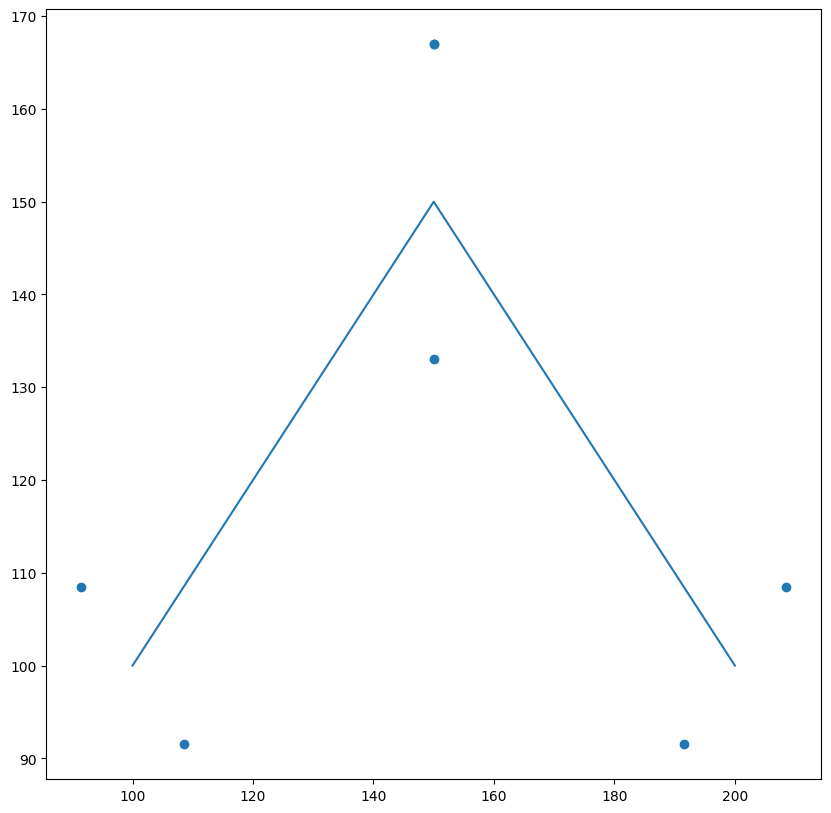

In [48]:
plt.figure(figsize=(10,10))
plt.plot(res_centerline[:,0],res_centerline[:,1])
plt.scatter(res_poly[:,0],res_poly[:,1])

In [13]:
lane_polygons

[[(91.51471862576143, 108.48528137423857),
  (108.48528137423857, 91.51471862576143),
  (158.48528137423858, 141.51471862576142),
  (141.51471862576142, 158.48528137423858),
  (191.51471862576142, 91.51471862576143),
  (208.48528137423858, 108.48528137423857)],
 [(245.7573593128807, 104.24264068711929),
  (254.2426406871193, 95.75735931288071),
  (304.24264068711926, 145.7573593128807),
  (295.75735931288074, 154.2426406871193),
  (345.75735931288074, 95.75735931288071),
  (354.24264068711926, 104.24264068711929)]]